<a href="https://colab.research.google.com/github/alyilmaz99/linear-regresyon-fake-news-predict/blob/main/linear_regresyon_news_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [90]:
import os
import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re
import torch
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, accuracy_score
import seaborn as sns



In [91]:
try:
    df = pd.read_csv('/content/WELFake_Dataset.csv')
except pd.errors.ParserError as e:
    print(f"ParserError: {e}")

df.head(5)


ParserError: Error tokenizing data. C error: EOF inside string starting at row 10710


,Unnamed: 0,title,text,label,full_text,clean_text
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",1,You Can Smell Hillary’s Fear Daniel Greenfield...,smell hillary fear daniel greenfield shillman ...
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,1,Watch The Exact Moment Paul Ryan Committed Pol...,watch exact moment paul ryan committed politic...
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,0,Kerry to go to Paris in gesture of sympathy U....,kerry paris gesture sympathy secretary state j...
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",1,Bernie supporters on Twitter erupt in anger ag...,bernie supporters twitter erupt anger dnc trie...
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,0,The Battle of New York: Why This Primary Matte...,battle new york primary matters primary day ne...


In [92]:
df.info()
df['label'] = df['label'].replace({'0': 0, '1': 1})
df['label'].value_counts()
df['full_text'] = df.apply(lambda row: row['title'] + ' ' + row['text'], axis=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   int64 
 4   full_text   6335 non-null   object
 5   clean_text  6335 non-null   object
dtypes: int64(2), object(4)
memory usage: 297.1+ KB


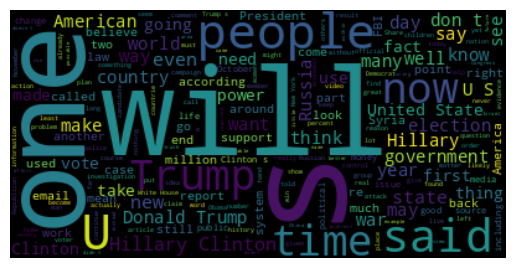

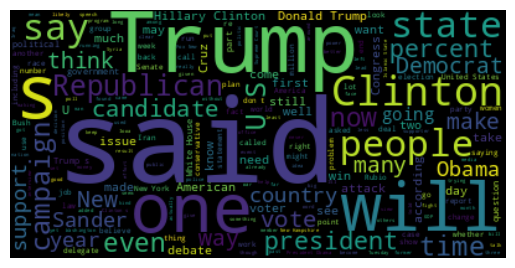

In [93]:
# separate texts with label = 1
text_1 = ' '.join(df[df['label']==1]['full_text'])

# create a word cloud
wordcloud_1 = WordCloud().generate(text_1)

plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.show()

# repeat for label = 0
text_0 = ' '.join(df[df['label']==0]['full_text'])
wordcloud_0 = WordCloud().generate(text_0)
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.show()

In [94]:
nltk.download('stopwords')
import gensim

stop_words = stopwords.words('english')
stop_words.extend(['one', 'will'])
def preprocess(text, join_back=True):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        # Stop Words Cleaning
        if (
            token not in gensim.parsing.preprocessing.STOPWORDS and
            # len(token) > 2 and
            token not in stop_words
        ):
            result.append(token)
    if join_back:
        result = " ".join(result)
    return result

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [95]:
df['clean_text']=df['full_text'].apply(preprocess)

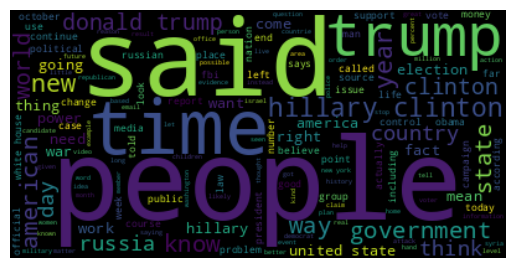

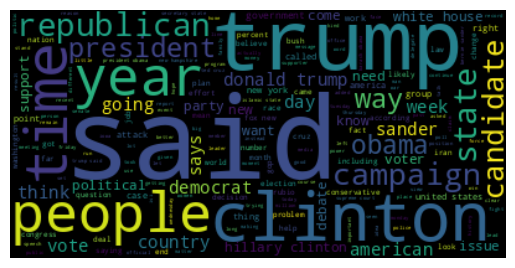

In [96]:

text_1 = ' '.join(df[df['label']==1]['clean_text'])


wordcloud_1 = WordCloud().generate(text_1)

plt.imshow(wordcloud_1, interpolation='bilinear')
plt.axis("off")
plt.show()

text_0 = ' '.join(df[df['label']==0]['clean_text'])
wordcloud_0 = WordCloud().generate(text_0)
plt.imshow(wordcloud_0, interpolation='bilinear')
plt.axis("off")
plt.show()

In [97]:
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(df['clean_text'], df['label'], test_size=0.2)

In [98]:
from sklearn.neural_network import MLPClassifier
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(
        analyzer='word',
        stop_words='english',
        ngram_range=(1, 3),
        lowercase=True,
        min_df=5,
        max_features=30000
    )),
    ('classifier', MLPClassifier(hidden_layer_sizes=(512,256,128,64,32)))
])

In [99]:
pipe.fit(train_texts, train_labels)



Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_features=30000, min_df=5,
                                 ngram_range=(1, 3), stop_words='english')),
                ('classifier',
                 MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64, 32)))])

In [100]:

def MakePrediction(model, X, y):
    predicted = model.predict(X)
    cm = confusion_matrix(y, predicted)
    plt.figure(2, figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    nunique = set(y)
    if(len(nunique)==2):
        precision = precision_score(y, predicted)
        recall = recall_score(y, predicted)
        f1 = f1_score(y, predicted)
        accuracy = accuracy_score(y, predicted)
    else:
        precision = precision_score(y, predicted, average='macro')
        recall = recall_score(y, predicted, average='macro')
        f1 = f1_score(y, predicted, average='macro')
        accuracy = accuracy_score(y, predicted)

    print(f'Precision: {precision}')
    print(f'Recall: {recall}')
    print(f'F1-score: {f1}')
    print(f'accuracy: {accuracy}')
    if(len(nunique) == 2):
        # Calculation and visualization of the ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y, predicted)
        roc_auc = roc_auc_score(y, predicted)

        plt.figure(3)
        plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
    plt.show()
    model = 0
    predicted = 0

Precision: 0.93026941362916
Recall: 0.9560260586319218
F1-score: 0.9429718875502008
accuracy: 0.9439621152328335


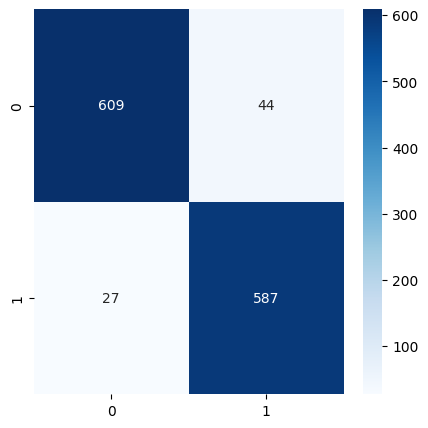

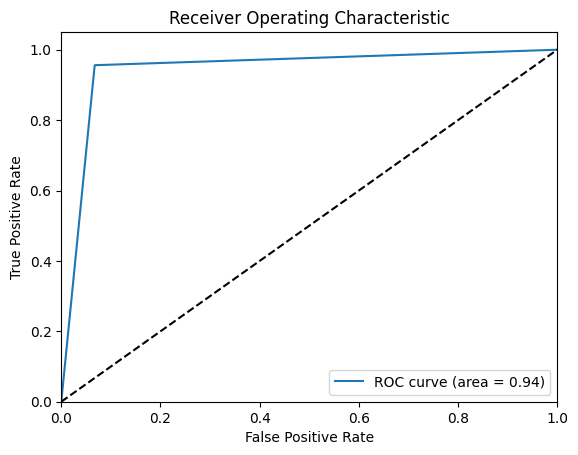

In [101]:
MakePrediction(pipe, test_texts, test_labels)

In [114]:
user_input = input("Bir metin giriniz: ")
user_input_list = [user_input]

prediction = pipe.predict(user_input_list)

if prediction <= 0.5:
    print("Giriş, gerçek haber olabilir.")
else:
    print("Giriş, sahte haber olabilir.")


Bir metin giriniz: But it is a bittersweet moment. In an interview with the BBC before she made her announcement, Ms Wolfe Herd lamented that, as a group of young women who came up in tech in the 2010s, not many are left.  "It is disappointing to see just how little women have advanced," she said. "I've watched the fall of what people call 'the girl boss era'. That's tragic."  However, Bumble will still be led by a woman - Lidiane Jones, the former boss of Slack, will take over as chief executive while Ms Wolfe Herd will stay on as executive chair.
Giriş, sahte haber olabilir.
